# Agriculture Parcels Vs Non-Agriculture Parcels

In [2]:
#Step 1: Load the original dataset having Landuse_Ma columon. This dataset also have crop information. 

import geopandas as gpd
import pandas as pd
import numpy as np
import leafmap
import geemap
import ee

In [7]:
cropfile = 'D:\Trainings\gee\pabb_crop_V3.geojson'
gdf = gpd.read_file(cropfile)
gdf['Landuse_Ma'].groupby(gdf['Landuse_Ma']).count().sort_values(ascending=False)

Landuse_Ma
Agriculture     5759
Stream           302
Other            229
Road/Streets     172
Graveyard         29
Built up          24
Name: Landuse_Ma, dtype: int64

In [8]:

selected_parcels = gdf[gdf['Landuse_Ma'] == 'Agriculture']
print(f'Total Agriculture Parcels are :{len(selected_parcels)}') 
# These are the parcels with Landuse_Ma as Agriculture and will be used for further analysis.

Total Agriculture Parcels are :5759


## Data Cleansing
1. Calculating NDVI and NDBI of the selected agriculture parcels : 5759.

In [9]:
# Lets Convert the gdf of the original file to ee features utilizing earth engine power
ee.Authenticate()

ee.Initialize()
boundary = geemap.gdf_to_ee(gdf) # this is for cliping the images
selectedparcels_fc = geemap.gdf_to_ee(selected_parcels) # this is for getting the agriculture parcels features Collection 


In [10]:
# Define a function to get imagery an apply filter
def get_collection (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(boundary.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    return filtered_collection

In [12]:
# defing ndvi , NDBI , BUI and UI indices

def get_ndvi(filtered_collection):
    # Calculate the annual NDVI from the filtered collection (filtered_collection)
    ndvi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # Calculate the mean NDVI for the year
    mean_ndvi = ndvi_collection.mean()
    return mean_ndvi
    
def get_ndbi(filtered_collection):
    # Calculate Normalized Difference Built-up Index (NDBI) (SWIR−NIR)/(SWIR+NIR) from the filtered collection filtered_collection
    # NDBI = (B11 - B8) / (B11 + B8)
    # Built‑up areas (positive values) vs. vegetation/water (negative)
    ndbi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B11', 'B8']).rename('NDBI'))
    # Calculate the mean NDBI for the year
    mean_ndbi = ndbi_collection.mean()
    return mean_ndbi
def get_ndwi(filtered_collection):
    # Calculate Normalized Difference Water Index (NDWI) (Green-NIR)/(Green+NIR) from the filtered collection filtered_collection
    # NDWI = (B3 - B8) / (B3 + B8)
    # Water (positive values) vs. built-up/vegetation (negative)
    ndwi_collection = filtered_collection.map(lambda img: img.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # Calculate the mean NDWI for the year
    mean_ndwi = ndwi_collection.mean()
    return mean_ndwi

def get_bui(filtered_collection):
    # Calculate the annual Built-Up Index (BUI) for an ee.ImageCollection `filtered_collection`.
    # BUI: (B11 + B4 - B8 - B2) / (B11 + B4 + B8 + B2)
    # Enhances urban density separation from other land‑covers
    bui_collection = filtered_collection.map(lambda img: (img.select('B11').add(img.select('B4')).subtract(img.select('B8'))
           .subtract(img.select('B2'))
           .divide(
               img.select('B11').add(img.select('B4'))
                  .add(img.select('B8'))
                  .add(img.select('B2'))
           )
           .rename('BUI')      
                    ))
    mean_bui = bui_collection.mean()
    return mean_bui
    
def get_ui(filtered_collection):
    # Calculate Urban Index (UI) (NDBI−NDVI)/(NDBI+NDVI) for the collection
    # Separates built‑up from vegetation more robustly
    mean_ndvi = get_ndvi(filtered_collection)
    mean_ndbi = get_ndbi(filtered_collection)
    mean_ui = mean_ndbi.subtract(mean_ndvi).divide(mean_ndbi.add(mean_ndvi)).rename('UI')
    return mean_ui



In [13]:
def get_composite(filtered_collection,ndvi_img, ndbi_img, bui_img, ui_img,ndwi_img):
    """
    Stack the four annual‐mean index images into one composite,
    then clip it to the boundary.
    """
    selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11']
    filtered_collection = filtered_collection.select(selected_bands)
    
    #Now add the indices to each image in the filtered collection
    filtered_collection = filtered_collection.map(lambda img: img.addBands(ndvi_img).addBands(ndbi_img).addBands(bui_img).addBands(ui_img).addBands(ndwi_img))  
    
    # Reduce the collection to a mean single image
    composite_img = filtered_collection.mean()
    
    # Rename the bands in the correct order
    composite_img = composite_img.rename(['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'NDBI', 'BUI', 'UI','NDWI'])
    
    # 3. Clip to your boundary
    composite_img = composite_img.clip(boundary.geometry())
    
    return composite_img


In [14]:
filtered_collection = get_collection('2022-01-01', '2024-12-31')
ndvi_img = get_ndvi(filtered_collection)
ndbi_img = get_ndbi(filtered_collection)
bui_img = get_bui(filtered_collection)
ui_img = get_ui(filtered_collection)
ndwi_img = get_ndwi(filtered_collection)

composite_img = get_composite(filtered_collection, ndvi_img, ndbi_img, bui_img, ui_img, ndwi_img)

In [15]:
Map = geemap.Map(center=(37.5,70), zoom=10)

# To confirm that the composite Image is cropped 
vis_tc = {
    'bands': ['B4','B3','B2'],  # Red, Green, Blue
    'min': 0, 'max': 3000,      # Sentinel-2 SR values ~0–3000
    'gamma': 1.2
}
Map.addLayer(composite_img, vis_tc, 'True Color Composite', True)

Map.center_object(boundary, 10)
Map


Map(center=[34.025104580270586, 71.77439126406186], controls=(WidgetControl(options=['position', 'transparent_…

In [16]:
def sum_count(filtered_collection, parcels_fc,agrithresh=0.3, builtdiff =0.0):
        
    flagged = filtered_collection.map(lambda img: mask_flags(img, agrithresh, builtdiff))
    
    count_image = flagged.select(['agri_count','built_count']).sum()

    stats_fc = count_image.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.sum(),
        scale=10,
        crs=count_image.projection()
    )
    return stats_fc


def mask_flags(img,agrithresh, builtdiff):
    
    #compute the NDVI and NDBI for each image in the collection
    ndvi = img.normalizedDifference(['B8', 'B4'])
    ndbi = img.normalizedDifference(['B11', 'B8'])
    # create a boolean mask and cast to int (1 if true and 0 if false)
    agri_flag = ndvi.gt(agrithresh).rename('agri_count').toInt()
    built_flag = ndbi.gt(builtdiff).rename('built_count').toInt()
    return img.addBands([agri_flag,built_flag])


In [17]:
# The composite Image which is mean of all the indices and bands is now used to 
# calculate the mean of each index and bands in the composite image.

def mean_indices(composite_img, parcels_fc):
    #Select the bands of interest
    b2 = composite_img.select('B2')
    b3 = composite_img.select('B3')
    b4 = composite_img.select('B4')
    b8 = composite_img.select('B8')
    b11 = composite_img.select('B11')


    # Select the indices
    ndvi = composite_img.select('NDVI')
    ndbi = composite_img.select('NDBI')
    ui = composite_img.select('UI')
    bui = composite_img.select('BUI')
    ndwi = composite_img.select('NDWI')

    index_img = ee.Image.cat([b2,b3,b4,b8,b11,ndvi,ndbi,bui,ui,ndwi])
    mean_img = index_img.reduceRegions(
        collection=parcels_fc,
        reducer=ee.Reducer.mean(),
        scale=10,
        crs=composite_img.projection()
    )
    return mean_img


In [18]:
pxlsum = sum_count(filtered_collection,selectedparcels_fc,agrithresh=0.3, builtdiff =0.0)
pxlmean = mean_indices(composite_img, selectedparcels_fc)
# Convert the ee.FeatureCollection to a pandas DataFrame
pxlsum_gdf= geemap.ee_to_gdf(pxlsum)
pxlmean_gdf= geemap.ee_to_gdf(pxlmean)  


In [19]:
pxlmean_gdf.head()

,geometry,Area_Acre,B11,B2,B3,B4,B8,BUI,Crop_Type,FFID,Landuse_Ma,Mouza_Name,NDBI,NDVI,NDWI,Parcel_ID,UI
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,2147.930654,1080.794583,1314.424346,1412.001354,2250.015724,0.037398,None,1,Agriculture,Khushmaqam,-0.016614,0.226656,-0.261929,668,-1.202087
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,2148.237869,905.980655,1133.265953,1248.493593,2115.168267,0.060771,None,3,Agriculture,Khushmaqam,0.013744,0.254974,-0.298905,632,-0.876391
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,2198.647527,989.403836,1234.108843,1331.561342,2231.942662,0.047527,None,4,Agriculture,Khushmaqam,-0.003842,0.248897,-0.284861,669,-1.022695
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,2193.297278,806.999988,1099.118312,1177.751882,2761.666157,-0.038227,None,5,Agriculture,Khushmaqam,-0.109844,0.410130,-0.431634,693,-1.738528
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,2126.134001,1160.127481,1376.297936,1480.144814,2196.267099,0.039058,None,6,Agriculture,Khushmaqam,-0.011919,0.197473,-0.233127,667,-1.196795


In [20]:
# since both dataframes have duplicate columns therefore to avoid duplicaiton 
# we will select the columns we need for merging
mean_cols = ['geometry','NDVI','NDBI','BUI','UI','NDWI','B2','B3','B4','B8','B11']
plxmean_small = pxlmean_gdf[mean_cols]

#Now we will merge the two dataframes
stats_gdf = pxlsum_gdf.merge(plxmean_small, on='geometry', how='left')

print(stats_gdf.columns.tolist())

['geometry', 'Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name', 'Parcel_ID', 'agri_count', 'built_count', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'B2', 'B3', 'B4', 'B8', 'B11']


In [21]:
# Now stats_gdf has columns 'built_count' and 'agri_count' per parcel
# Lets compute the percentage of built and agri land
stats_gdf['pct_built'] = stats_gdf['built_count'] / (stats_gdf['built_count'] + stats_gdf['agri_count'])
stats_gdf['pct_agri']  = stats_gdf['agri_count']  / (stats_gdf['built_count'] + stats_gdf['agri_count'])


In [22]:
stats_gdf

,geometry,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,NDVI,...,BUI,UI,NDWI,B2,B3,B4,B8,B11,pct_built,pct_agri
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,None,1,Agriculture,Khushmaqam,668,90.725490,181.058824,0.226656,...,0.037398,-1.202087,-0.261929,1080.794583,1314.424346,1412.001354,2250.015724,2147.930654,0.666186,0.333814
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,None,3,Agriculture,Khushmaqam,632,445.384314,928.509804,0.254974,...,0.060771,-0.876391,-0.298905,905.980655,1133.265953,1248.493593,2115.168267,2148.237869,0.675823,0.324177
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,None,4,Agriculture,Khushmaqam,669,241.717647,430.784314,0.248897,...,0.047527,-1.022695,-0.284861,989.403836,1234.108843,1331.561342,2231.942662,2198.647527,0.640570,0.359430
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,None,5,Agriculture,Khushmaqam,693,955.690196,434.231373,0.410130,...,-0.038227,-1.738528,-0.431634,806.999988,1099.118312,1177.751882,2761.666157,2193.297278,0.312414,0.687586
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,None,6,Agriculture,Khushmaqam,667,170.831373,437.709804,0.197473,...,0.039058,-1.196795,-0.233127,1160.127481,1376.297936,1480.144814,2196.267099,2126.134001,0.719277,0.280723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,"POLYGON ((71.76623 34.0439, 71.76626 34.04366,...",0.171500,None,6723,Agriculture,Amankot,843,1553.215686,112.615686,0.571489,...,-0.101405,-1.856395,-0.555056,460.745576,706.997455,669.423946,2584.963943,1786.159601,0.067603,0.932397
5755,"POLYGON ((71.76681 34.0447, 71.76711 34.04347,...",0.466952,None,6724,Agriculture,Amankot,848,2741.811765,1695.423529,0.420987,...,-0.035676,-1.744243,-0.461200,606.152732,866.504644,990.755175,2359.760189,1915.876354,0.382090,0.617910
5756,"POLYGON ((71.77762 34.02896, 71.77766 34.02877...",-0.303899,None,6725,Agriculture,Amankot,1331,3572.301961,813.478431,0.488737,...,-0.062202,-1.782541,-0.494530,601.428608,912.079541,938.331616,2769.259731,2078.009210,0.185481,0.814519
5757,"POLYGON ((71.79385 34.02814, 71.79411 34.02642...",3.634200,None,6726,Agriculture,Amankot,2070,45075.819608,22076.682353,0.417301,...,-0.031983,-1.711403,-0.453149,676.936347,959.914195,1077.387722,2598.212482,2088.983032,0.328754,0.671246


In [23]:
def high_confidence_label(row,
                          ndvi_ag=0.35,     # only very green
                          ui_ag_max=0.05,   # near zero build
                          pa_ag=0.80,       # ≥80% ag cover
                          ui_non=0.25,      # definitely built
                          pb_non=0.50       # ≥50% built cover
                         ):
    ndvi = row['NDVI']
    ui   = row['UI']
    pa   = row['pct_agri']
    pb   = row['pct_built']
    
    # HIGH-CONFIDENCE AGRICULTURE
    if ndvi >= ndvi_ag and ui <= ui_ag_max and pa >= pa_ag:
        return 'Agriculture'
    
    # HIGH-CONFIDENCE NON-AGRICULTURE
    if ui >= ui_non or pb >= pb_non:
        return 'Non-Agriculture'
    
    # UNCERTAIN
    return None

stats_gdf['hc_label'] = stats_gdf.apply(high_confidence_label, axis=1)
print(stats_gdf['hc_label'].value_counts())

hc_label
Agriculture        1985
Non-Agriculture    1425
Name: count, dtype: int64


In [24]:
agriculture = stats_gdf[stats_gdf['hc_label'] == 'Agriculture']
nonagriculture = stats_gdf[stats_gdf['hc_label'] == 'Non-Agriculture']


In [25]:
#This map just give you the visualization of High confident labels

m = leafmap.Map(center=(37.5, 70), )
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + landuse_class
popup_gdf = stats_gdf[['geometry', 'hc_label']].copy()


legend_dict = {
    'Agriculture':           '#00AA00',  # dark green
    'Non-Agriculture':       '#00008B',  # darkblue
    }


m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={                      # pick any style you like
        'color':   'black',
        'fillColor':'transparent',
        'fillOpacity': 0.1,
        'weight':  1
    },
    zoom_to_layer=True,
    info_mode='on_click'        # show popup when you click
)

# Agriculture
m.add_gdf(
    agriculture,
    layer_name='Agriculture',
    style={
        'color': 'green',      # border
        'fillColor': 'green',  # interior
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
     
)
# Non-Agriculture
m.add_gdf(
    nonagriculture,
    layer_name='Non-Agriculture',
    style={
        'color': 'blue',
        'fillColor': 'blue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
    
)
# Add legend
m.add_legend(
    legend_title='Landuse Classification',
    legend_dict=legend_dict,
    position='bottomleft'
)

m.add_layer_manager()

m

Map(center=[37.5, 70], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [105]:
#len(stats_gdf)
#stats_gdf.head()



# Adding the land classification raster
colorlist = ['green','blue']
classified_img = 'D:/Trainings/gee/classified_image-V2-clipped.tif'

#clippedimage = imagepath.clip(boundary.geometry())


m.add_raster(
    classified_img,
    layer_name='Landuse Classification',
    colormap= colorlist,
    opacity=0.5,
    vmin=0,
    vmax=4,
    nodata=None,
    legend=True,
    layer_opacity=0.5
)

m.add_layer_manager()

# Training Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#prepare training data
train = stats_gdf.dropna(subset = ['hc_label'])

X = train[['NDVI','UI','BUI','NDBI','NDWI','B2','B3','B4','B8','B11']].values
y = (train['hc_label'] == 'Agriculture').astype(int)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

#Train the model
rf= RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train ,y_train)
y_pred = rf.predict(X_test)

In [27]:
#Priting classification report and Confusion matrix
# Evaluate the Performance of the model

# 5) Print the classification report
print("Classification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-Agriculture','Agriculture']
))

# 6) Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Classification Report:

                 precision    recall  f1-score   support

Non-Agriculture       0.99      0.98      0.99       285
    Agriculture       0.99      0.99      0.99       397

       accuracy                           0.99       682
      macro avg       0.99      0.99      0.99       682
   weighted avg       0.99      0.99      0.99       682

Confusion Matrix:
 [[279   6]
 [  2 395]]


In [28]:
# Predicting the unlabeled Parcels

unlabeled = stats_gdf[stats_gdf['hc_label'].isna()]

X_unlbl = unlabeled[['NDVI','UI','BUI','NDBI','NDWI','B2','B3','B4','B8','B11']].values

probs = rf.predict_proba(X_unlbl)[:,1]
unlabeled['rf_prob_ag'] = probs

#Hard-Classify at 0.5 (threshold)

unlabeled['rf_label'] = np.where(probs>0.5, 'Agriculture', 'Non-Agriculture')

In [29]:
# To leave the very low confidence RF Preictions unassigned.
threshold_low , threshold_high= 0.3,0.7

unlabeled['predicted_label'] = np.where(probs > threshold_high, 'Agriculture',
                                        np.where(probs < threshold_low, 'Non-Agriculture', None))


In [30]:
pred_agri = unlabeled[unlabeled['predicted_label']== 'Agriculture']
pred_nonagri = unlabeled[unlabeled['predicted_label']== 'Non-Agriculture']
pred_unassigned = unlabeled[unlabeled['predicted_label']== None]

In [31]:
# Lets Create one Final dataset with target_labels for crop Random Forest
stats_gdf = stats_gdf.merge(unlabeled[['FFID','predicted_label']], on='FFID',how= 'left')
stats_gdf['target_label'] = stats_gdf['hc_label'].fillna(stats_gdf['predicted_label'])

stats_gdf.head()

,geometry,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,NDVI,...,B2,B3,B4,B8,B11,pct_built,pct_agri,hc_label,predicted_label,target_label
0,"POLYGON ((71.74996 34.03193, 71.75027 34.03195...",0.101785,None,1,Agriculture,Khushmaqam,668,90.725490,181.058824,0.226656,...,1080.794583,1314.424346,1412.001354,2250.015724,2147.930654,0.666186,0.333814,Non-Agriculture,NaN,Non-Agriculture
1,"POLYGON ((71.74868 34.03205, 71.74869 34.03195...",0.315557,None,3,Agriculture,Khushmaqam,632,445.384314,928.509804,0.254974,...,905.980655,1133.265953,1248.493593,2115.168267,2148.237869,0.675823,0.324177,Non-Agriculture,NaN,Non-Agriculture
2,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,...",0.187644,None,4,Agriculture,Khushmaqam,669,241.717647,430.784314,0.248897,...,989.403836,1234.108843,1331.561342,2231.942662,2198.647527,0.640570,0.359430,Non-Agriculture,NaN,Non-Agriculture
3,"POLYGON ((71.75401 34.03224, 71.75403 34.03219...",0.161568,None,5,Agriculture,Khushmaqam,693,955.690196,434.231373,0.410130,...,806.999988,1099.118312,1177.751882,2761.666157,2193.297278,0.312414,0.687586,None,Agriculture,Agriculture
4,"POLYGON ((71.74971 34.03192, 71.74996 34.03193...",0.229336,None,6,Agriculture,Khushmaqam,667,170.831373,437.709804,0.197473,...,1160.127481,1376.297936,1480.144814,2196.267099,2126.134001,0.719277,0.280723,Non-Agriculture,NaN,Non-Agriculture


In [34]:
stats_gdf.to_file('Pabbi_AgriVsNonAgri-V-1.geojson')

In [40]:
# Lets save the model for future use
import joblib
joblib.dump(rf, 'agri_nonagri-V1.pkl')   

['agri_nonagri-V1.pkl']

In [32]:
m = leafmap.Map(center=(37.5, 70), zoom=6)
m.add_basemap('Google Satellite')

# 1. Create a minimal GeoDataFrame with only geometry + Target Labels
popup_gdf = stats_gdf[['geometry', 'target_label']].copy()

# 2. Add your styling layers *without* popups
layers_lsit = [ 
    (agriculture,    'Agriculture',             legend_dict['Agriculture']),
    (nonagriculture,   'NonAgricultrue',        legend_dict['Non-Agriculture']),
        ]

for gdf, name, color in layers_lsit:
    # 2.1 Add the layer to the map   
    m.add_gdf(
        gdf,
        layer_name=name,
        style={
            'color':    color,
            'fillColor':color,
            'fillOpacity':0.3,
            'weight':   1
        },
        zoom_to_layer=True,
        info_mode='off'   # make sure no popups for these layers
    )

# 3. Add your minimal layer *last*, with popups ON only for landuse_class
m.add_gdf(
    popup_gdf,
    layer_name='Landuse Class',
    style={
        'color':      'black',
        'fillColor': 'transparent',
        'fillOpacity':0.1,
        'weight':     1
    },
    info_mode='on_click'  # only this layer shows a popup
)

# Adding the predicted Agriculture and Non-Agriculture parcels
m.add_gdf(
    pred_agri,
    layer_name='Predicted Agriculture',
    style={
        'color': 'lightgreen',
        'fillColor': 'lightgreen',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)
m.add_gdf(
    pred_nonagri,
    layer_name='Predicted Non-Agriculture',
    style={
        'color': 'lightblue',
        'fillColor': 'lightblue',
        'fillOpacity': 0.4,
        'weight': 1
    }, info_mode='off'
)


# 4. Legend & Layer Manager
m.add_legend(
    legend_title='Agriculture vs Non-Agriculture',
    legend_dict=legend_dict,
    position='bottomleft'
)

m.add_layer_manager()

m


Map(center=[37.5, 70], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Multiband Classified Vector 

# This is one time activity to create the composite image marked it down

bands = ['NDVI','UI','BUI','NDBI','NDWI','B2','B3','B4','B8','B11']
stacked = composite_img.select(bands)

# Export the image to a local GeoTiff at 10m resolution
out_tif = 'Pabbi_AgriVsNonAgri-V-1.tif'

geemap.ee_export_image(
    stacked,
    filename=out_tif,
    scale=10,
    region=boundary.geometry().bounds(),                 # your AOI
    file_per_band=False,                        # one multiband file
    crs='EPSG:4326' ,                            # or your preferred CRS
    
)

print(f"Exported multiband GeoTIFF: {out_tif}")


In [62]:
# 1. Load your trained RF pipeline
rf_model = joblib.load('./agri_nonagri-V1.pkl')
feature_cols = ['NDVI','UI','BUI','NDBI','NDWI','B2','B3','B4','B8','B11']
classes  = rf_model.classes_

In [ ]:
# 2 Open the 10-band GeoTIFF file
import rasterio

with rasterio.open('Pabbi_AgriVsNonAgri-V-1.tif') as src:
    profile = src.profile.copy()
    data = src.read()  # Read all bands into a 3D numpy array shape (bands, height, width)
    assert data.shape[0] == len(feature_cols),f"Expected {len(feature_cols)} bands, found {data.shape[0]} bands in the file."

In [64]:
# 3 Prepare the feature array (pixels x features)
bands , h, w = data.shape
#transpose to (h,w,bands) then reshape to (h*w,bands)
X = np.transpose(data, (1,2,0)).reshape(-1,bands)
X.shape

(570064, 10)

In [65]:
# 4 Predict every pixel
y_flat = rf_model.predict(X)  # Predict the class labels for each pixel
print(y_flat.shape)

(570064,)


In [66]:
# 5 Reshape back to 2D
classified = y_flat.reshape(h,w).astype(np.uint8)  # Reshape to (height, width) and convert to uint8  

In [67]:
#6 write out the classified raster
out_profile = profile.copy()
out_profile.update({
    'dtype': 'uint8',
    'count': 1,
    'compress': 'lzw',
    'nodata': 0
})
with rasterio.open('Agri_NonAgri-V1.tif', 'w', **out_profile) as dst:
    dst.write(classified, 1)  # Write the classified data to the first band
print("Exported classified image: Agri_NonAgri-V1.tif")

Exported classified image: Agri_NonAgri-V1.tif


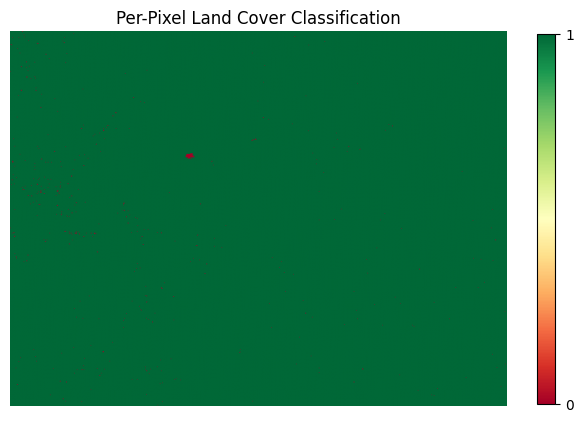

In [68]:
import matplotlib.pyplot as plt

vmin,vmax = 0,len(classes)-1

# Map class codes back to names, if you saved them
if classes is not None:
    cmap = plt.get_cmap('tab10', len(classes))
else:
    cmap = 'viridis'

with rasterio.open('classified_image-V3.tif') as src:
    img = src.read(1)

plt.figure(figsize=(8,8))
im = plt.imshow(img, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.axis('off')
cbar = plt.colorbar(im, ticks=np.arange(len(classes)),shrink=0.6)
cbar.ax.set_yticklabels(classes)
plt.title("Per-Pixel Land Cover Classification")
plt.show()


import rasterio

with rasterio.open('Pabbi_AgriVsNonAgri-V-1.tif') as src:
    profile = src.profile.copy()
    feature_cube = src.read().astype(np.float32)
print(profile)
print(feature_cube.shape)
bands,height,width = feature_cube.shape

# NOw lets Flatten the array and predict 
flattened_per_band = feature_cube.reshape(bands,height*width)
X_pixels = flattened_per_band.T
print(X_pixels.shape)




In [48]:
y_flat = rf_model.predict(X_pixels)  # Predict the class labels for each pixel
classes  = rf.classes_

print(y_flat.shape)

print(classes)

(570064,)
[0 1]


In [ ]:
# 5 Reshape back to 2D
classified = y_flat.reshape(h,w).astype(np.uint8)  # Reshape to (height, width) and convert to uint8  

In [35]:
# Reshape back to raster form

n_classes = probs.shape[1]

# One probability per class
probs_rasters = probs.T.reshape(n_classes, height, width)

# One hard-classification band

pred_raster = pred.reshape(height,width).astype(np.uint8)

print(pred_raster.shape)
print(probs_rasters.shape)


(656, 869)
(2, 656, 869)


In [36]:
# Write the multband geotiff
# 1) Clean up profile
out_profile = profile.copy()
out_profile.update({
    'dtype':    'float32',
    'count':    n_classes + 1,
    'compress': 'lzw',
})
out_profile.pop('nodata', None)         # ensure no nodata masking

# 2) Clean arrays
import numpy as np
prob_rasters = np.nan_to_num(probs_rasters, nan=0.0)
pred_raster  = np.nan_to_num(pred_raster,  nan=0).astype(np.float32)

# 3) Write to disk
with rasterio.open('lc_prob_and_pred.tif', 'w', **out_profile) as dst:
    # Prob bands
    for i, cls in enumerate(classes, start=1):
        dst.write(prob_rasters[i-1], i)
        dst.set_band_description(i, f'Prob_{cls}')
    # Hard‐class band
    dst.write(pred_raster, n_classes + 1)
    dst.set_band_description(n_classes + 1, 'Predicted_Class_ID')

print("Export complete: lc_prob_and_pred.tif")


Export complete: lc_prob_and_pred.tif


In [37]:
with rasterio.open('lc_prob_and_pred.tif') as src:
    for i in range(1, src.count+1):
        band = src.read(i)
        print(f"Band {i} ({src.descriptions[i-1]}): min={band.min():.3f}, max={band.max():.3f}")


Band 1 (Prob_0): min=0.385, max=0.385
Band 2 (Prob_1): min=0.615, max=0.615
Band 3 (Predicted_Class_ID): min=1.000, max=1.000


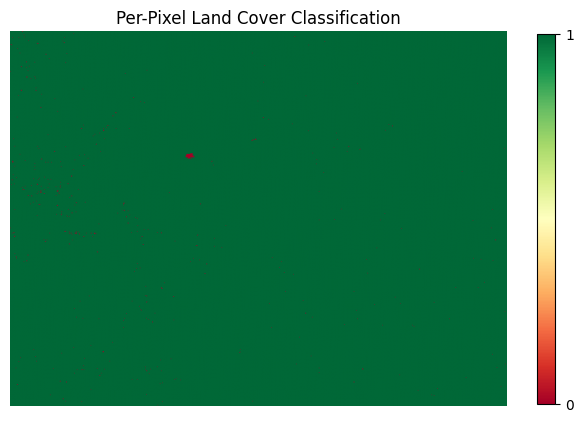

In [38]:
import matplotlib.pyplot as plt

vmin,vmax = 0,len(classes)-1

# Map class codes back to names, if you saved them
if classes is not None:
    cmap = plt.get_cmap('tab10', len(classes))
else:
    cmap = 'viridis'

with rasterio.open('classified_image-V3.tif') as src:
    img = src.read(1)

plt.figure(figsize=(8,8))
im = plt.imshow(img, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.axis('off')
cbar = plt.colorbar(im, ticks=np.arange(len(classes)),shrink=0.6)
cbar.ax.set_yticklabels(classes)
plt.title("Per-Pixel Land Cover Classification")
plt.show()
